In [3]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
import time

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext

from gensim.models.keyedvectors import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder

import random
import string
import copy

from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt

In [60]:
GLOVE = 1 #Whether to use GloVe vectors or not
BATCH_SIZE = 256

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

In [9]:
df = pd.read_pickle("./nlp_genre/df_bal_kayla.pkl")
df_test = pd.read_pickle("./nlp_genre/df_test_kayla.pkl")

In [10]:
full_df = pd.concat([df[['lyrics_nsw_alpha_en', 'Genre']], df_test[['lyrics_nsw_alpha_en', 'Genre']]], axis=0).reset_index(drop=True)

In [11]:
le = LabelEncoder()
y = torch.tensor(le.fit_transform(full_df['Genre']))

tensor([5, 5, 5,  ..., 3, 5, 5])

In [12]:
class Sequences(Dataset):
    def __init__(self, path, y, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        self.vectorizer = CountVectorizer(max_df = 0.6)
        self.vectorizer.fit(df['lyrics_nsw_alpha_en'].tolist())
        self.token2idx = self.vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        # self.token2idx['<UNK>'] = max(self.token2idx.values()) + 1

        tokenizer = self.vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx] # Encode sentences to list of numbers based on token2idx
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df['lyrics_nsw_alpha_en'].tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df['Genre'].tolist()) if sequence])
        self.labels = y
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [13]:
dataset = Sequences(full_df, y, max_seq_len=100)

In [33]:
len(list(dataset.token2idx.values())) # All values are continuous

26271

In [35]:
glove = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                               
100%|█████████▉| 399999/400000 [00:15<00:00, 26446.55it/s]


In [36]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [37]:
get_word('google')

tensor([ 0.2257, -0.5625, -0.0516, -0.0794,  1.1876, -0.4840, -0.2334, -0.8528,
         0.9750, -0.3334,  0.7169,  0.1264,  0.3196, -1.4136, -0.5790, -0.0373,
        -0.0164,  0.4516, -0.2900,  0.5260, -0.2253, -0.2956, -0.0324,  1.5608,
        -0.0135, -0.0646,  0.2663,  0.7860, -0.7169, -0.9302,  0.8046,  1.6035,
        -0.3060, -0.3476,  0.9387,  0.3814, -0.2674, -0.5652,  0.5890, -0.1455,
        -0.3432,  0.2129, -0.3989,  0.0900, -0.8495,  0.3880, -0.5045, -0.2249,
         1.0644, -0.2624,  1.0334,  0.0635, -0.3999,  0.2424, -0.6564, -1.8107,
        -0.0618,  0.1380,  1.1658, -0.3005, -0.5014,  0.1651,  0.0398,  0.6254,
         0.5694,  0.6413,  0.2131,  0.3028,  0.3967,  0.3897,  0.2818,  0.7948,
        -0.1196, -0.4960, -0.5319, -0.1490,  0.5125, -0.3921, -0.5853, -0.0785,
         0.8172, -0.7350, -0.6813,  0.0992, -0.8761,  0.0296,  0.3340, -0.1431,
         0.1696, -0.0352,  0.3978,  0.7177,  0.2587, -0.3620,  0.4570, -0.3916,
        -0.4934, -0.1122,  0.2905,  0.73

In [85]:
matrix_len = len(dataset.token2idx)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

for i, word in enumerate(dataset.token2idx):
    try: 
        weights_matrix[i] = get_word(word)
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))

if torch.cuda.is_available():
    weights_matrix = torch.from_numpy(weights_matrix)

In [86]:
weights_matrix[0]

tensor([-0.5609,  0.2899,  0.0602, -0.1321,  0.7898,  1.0458, -0.1408, -0.4544,
        -0.4954, -0.4279,  0.2538, -0.1159,  0.1499,  0.6569,  0.0729, -0.1770,
         0.4742, -0.0223, -0.5012,  0.4231,  0.1767, -0.3700,  0.0698,  0.1593,
         0.3309, -0.5657, -0.2016, -0.2857, -0.1730,  0.2968,  0.0069,  0.3313,
        -0.1981,  0.0917, -0.3909,  0.4976,  0.0683, -0.1478, -0.4010, -0.1988,
        -0.2229,  0.5856, -0.1999,  0.8001, -0.0515, -0.8825, -0.7649, -0.9991,
        -0.0395, -0.0076,  0.5438,  0.4691,  0.9573,  0.4700, -0.1662, -1.9906,
        -0.2407,  0.0561,  0.9102,  0.2455,  0.4053,  1.1699, -0.5612, -0.6298,
         1.3325, -0.8780,  0.6988,  1.2443,  0.0113, -0.1507, -0.3130,  1.0510,
         0.2988, -0.2263,  0.0576,  0.7482, -0.1628,  0.3070, -1.1076, -0.3732,
        -0.2477, -0.5877, -0.3281, -0.4841, -1.6908,  0.3154,  0.2147, -1.0659,
        -0.3925, -0.1047, -0.2477,  0.0039, -0.4360,  0.1751,  0.3898,  0.4952,
        -0.5688, -0.7036, -0.4410, -0.05

In [14]:
train_split = 0.7
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [101]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True, num_workers = 8)

In [103]:
class LSTM(nn.Module):
    def __init__(
        self,
        batch_size,
        vocab_size = None,
        weights_matrix = None,
        embedding_dimension=300,
        hidden_size=64, 
        n_layers=1,
        device=device,
        dropout=0.2
    ):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        
        if weights_matrix is not None:
            self.encoder, num_embeddings, embedding_dimension = self.create_emb_layer(weights_matrix, True)
        else:
            self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        
        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            dropout=dropout,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 32)
        self.relu =nn.ReLU()
        self.do = nn.Dropout(p=dropout)
        self.decoder = nn.Linear(hidden_size, 6)
        self.sm = nn.Softmax(1)
        
    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.shape
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        
        if non_trainable:
            emb_layer.weight.requires_grad = False

        return emb_layer, num_embeddings, embedding_dim
        
    def init_hidden(self):
        h0 = torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
        c0 = torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
        return (h0, c0)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        h0, c0 = self.init_hidden()
        encoded = self.encoder(inputs) # 512x128 -> 512x128x100
        output, (hidden, cell) = self.rnn(encoded, (h0, c0)) #512x128x100 -> 512x128x128
        # output = self.fc(output[:, -1, :])
        # output = self.relu(output)
        # output = self.do(output)
        output = self.decoder(output[:, -1, :]).squeeze() #512x128 -> 512x6
        output = self.sm(output)
        return output

In [104]:
if GLOVE:
    model = LSTM(
        hidden_size=32,
        weights_matrix = weights_matrix,
        device=device,
        batch_size=batch_size,
    )    
else:
    model = LSTM(
        hidden_size=256,
        vocab_size=len(dataset.token2idx),
        device=device,
        batch_size=batch_size,
    )
model = model.to(device)
model

LSTM(
  (encoder): Embedding(26271, 100)
  (rnn): LSTM(100, 32, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (do): Dropout(p=0.2, inplace=False)
  (decoder): Linear(in_features=32, out_features=6, bias=True)
  (sm): Softmax(dim=1)
)

In [106]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [107]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim=1, keepdim=True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum().to(device)/torch.FloatTensor([y.shape[0]]).to(device)

In [108]:
def train(model, train_loader):
    model.train()
    progress_bar = tqdm_notebook(train_loader, leave=False)
    train_batch_losses = []
    train_batch_accuracy = []
    total = 0
    
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(inputs).to(device)
        # print(output.shape, target.shape)
        loss = criterion(output, target)
        acc = categorical_accuracy(output, target)
        
        loss.backward()
              
        # nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        train_batch_losses.append(loss.item())
        train_batch_accuracy.append(acc.item())
        total += 1
    # print(output.shape, target.shape)    
    return train_batch_losses, train_batch_accuracy, total
    

In [109]:
def evalu(model, test_loader):
    model.eval()
    progress_bar = tqdm_notebook(test_loader, leave=False)
    eval_batch_loss = []
    eval_batch_acc = []
    total = 0

    with torch.no_grad():
        for inputs, target in progress_bar:
            inputs, target = inputs.to(device), target.to(device)
            predictions = model(inputs)

            loss = criterion(predictions, target)

            acc = categorical_accuracy(predictions, target)

            eval_batch_loss.append(loss.item())
            eval_batch_acc.append(acc.item())
            total += 1
    
    return eval_batch_loss, eval_batch_acc, total

In [112]:
train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []
for epoch in range(50):
    train_batch_losses, train_batch_accuracy, total = train(model, train_loader)
    eval_batch_loss, eval_batch_acc, total_ = evalu(model, test_loader)

    
    train_epoch_loss = sum(train_batch_losses) / total
    train_epoch_acc = sum(train_batch_accuracy) / total
    
    eval_epoch_loss = sum(eval_batch_loss) / total_
    eval_epoch_acc = sum(eval_batch_acc) / total_
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    
    eval_losses.append(eval_epoch_loss)
    eval_accuracy.append(eval_epoch_acc)
    
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {train_epoch_loss:.3f} \tTrain Accuracy: {train_epoch_acc:.3f}')
    tqdm.write(f'Epoch #{epoch + 1}\tEval Loss: {eval_epoch_loss:.3f} \tEval Accuracy: {eval_epoch_acc:.3f}')

/tmp/ipykernel_15799/589472987.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #1	Train Loss: 1.645 	Train Accuracy: 0.384
Epoch #1	Eval Loss: 1.652 	Eval Accuracy: 0.375


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #2	Train Loss: 1.637 	Train Accuracy: 0.393
Epoch #2	Eval Loss: 1.650 	Eval Accuracy: 0.376


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #3	Train Loss: 1.631 	Train Accuracy: 0.396
Epoch #3	Eval Loss: 1.644 	Eval Accuracy: 0.379


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #4	Train Loss: 1.628 	Train Accuracy: 0.400
Epoch #4	Eval Loss: 1.644 	Eval Accuracy: 0.381


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #5	Train Loss: 1.624 	Train Accuracy: 0.404
Epoch #5	Eval Loss: 1.641 	Eval Accuracy: 0.386


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #6	Train Loss: 1.622 	Train Accuracy: 0.407
Epoch #6	Eval Loss: 1.640 	Eval Accuracy: 0.385


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #7	Train Loss: 1.620 	Train Accuracy: 0.409
Epoch #7	Eval Loss: 1.634 	Eval Accuracy: 0.392


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #8	Train Loss: 1.615 	Train Accuracy: 0.414
Epoch #8	Eval Loss: 1.634 	Eval Accuracy: 0.389


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #9	Train Loss: 1.613 	Train Accuracy: 0.418
Epoch #9	Eval Loss: 1.636 	Eval Accuracy: 0.387


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #10	Train Loss: 1.611 	Train Accuracy: 0.418
Epoch #10	Eval Loss: 1.632 	Eval Accuracy: 0.390


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #11	Train Loss: 1.609 	Train Accuracy: 0.420
Epoch #11	Eval Loss: 1.631 	Eval Accuracy: 0.391


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #12	Train Loss: 1.609 	Train Accuracy: 0.419
Epoch #12	Eval Loss: 1.632 	Eval Accuracy: 0.391


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #13	Train Loss: 1.606 	Train Accuracy: 0.423
Epoch #13	Eval Loss: 1.628 	Eval Accuracy: 0.393


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #14	Train Loss: 1.601 	Train Accuracy: 0.427
Epoch #14	Eval Loss: 1.625 	Eval Accuracy: 0.397


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #15	Train Loss: 1.602 	Train Accuracy: 0.428
Epoch #15	Eval Loss: 1.625 	Eval Accuracy: 0.395


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #16	Train Loss: 1.596 	Train Accuracy: 0.433
Epoch #16	Eval Loss: 1.623 	Eval Accuracy: 0.399


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #17	Train Loss: 1.594 	Train Accuracy: 0.435
Epoch #17	Eval Loss: 1.624 	Eval Accuracy: 0.397


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #18	Train Loss: 1.595 	Train Accuracy: 0.435
Epoch #18	Eval Loss: 1.636 	Eval Accuracy: 0.386


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #19	Train Loss: 1.596 	Train Accuracy: 0.432
Epoch #19	Eval Loss: 1.630 	Eval Accuracy: 0.393


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #20	Train Loss: 1.593 	Train Accuracy: 0.437
Epoch #20	Eval Loss: 1.628 	Eval Accuracy: 0.397


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #21	Train Loss: 1.588 	Train Accuracy: 0.443
Epoch #21	Eval Loss: 1.624 	Eval Accuracy: 0.400


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #22	Train Loss: 1.587 	Train Accuracy: 0.444
Epoch #22	Eval Loss: 1.618 	Eval Accuracy: 0.408


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #23	Train Loss: 1.585 	Train Accuracy: 0.449
Epoch #23	Eval Loss: 1.616 	Eval Accuracy: 0.410


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #24	Train Loss: 1.581 	Train Accuracy: 0.452
Epoch #24	Eval Loss: 1.620 	Eval Accuracy: 0.406


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #25	Train Loss: 1.579 	Train Accuracy: 0.455
Epoch #25	Eval Loss: 1.614 	Eval Accuracy: 0.413


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #26	Train Loss: 1.577 	Train Accuracy: 0.456
Epoch #26	Eval Loss: 1.619 	Eval Accuracy: 0.406


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #27	Train Loss: 1.576 	Train Accuracy: 0.457
Epoch #27	Eval Loss: 1.618 	Eval Accuracy: 0.409


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #28	Train Loss: 1.575 	Train Accuracy: 0.459
Epoch #28	Eval Loss: 1.616 	Eval Accuracy: 0.411


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #29	Train Loss: 1.571 	Train Accuracy: 0.463
Epoch #29	Eval Loss: 1.615 	Eval Accuracy: 0.412


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #30	Train Loss: 1.571 	Train Accuracy: 0.463
Epoch #30	Eval Loss: 1.612 	Eval Accuracy: 0.414


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #31	Train Loss: 1.570 	Train Accuracy: 0.464
Epoch #31	Eval Loss: 1.611 	Eval Accuracy: 0.414


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #32	Train Loss: 1.566 	Train Accuracy: 0.469
Epoch #32	Eval Loss: 1.612 	Eval Accuracy: 0.415


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #33	Train Loss: 1.563 	Train Accuracy: 0.473
Epoch #33	Eval Loss: 1.613 	Eval Accuracy: 0.415


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #34	Train Loss: 1.561 	Train Accuracy: 0.475
Epoch #34	Eval Loss: 1.610 	Eval Accuracy: 0.416


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #35	Train Loss: 1.560 	Train Accuracy: 0.477
Epoch #35	Eval Loss: 1.614 	Eval Accuracy: 0.416


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #36	Train Loss: 1.556 	Train Accuracy: 0.481
Epoch #36	Eval Loss: 1.616 	Eval Accuracy: 0.411


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #37	Train Loss: 1.557 	Train Accuracy: 0.481
Epoch #37	Eval Loss: 1.611 	Eval Accuracy: 0.417


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #38	Train Loss: 1.558 	Train Accuracy: 0.479
Epoch #38	Eval Loss: 1.612 	Eval Accuracy: 0.416


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #39	Train Loss: 1.552 	Train Accuracy: 0.487
Epoch #39	Eval Loss: 1.609 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #40	Train Loss: 1.553 	Train Accuracy: 0.484
Epoch #40	Eval Loss: 1.609 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #41	Train Loss: 1.550 	Train Accuracy: 0.488
Epoch #41	Eval Loss: 1.607 	Eval Accuracy: 0.422


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #42	Train Loss: 1.548 	Train Accuracy: 0.491
Epoch #42	Eval Loss: 1.609 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #43	Train Loss: 1.548 	Train Accuracy: 0.490
Epoch #43	Eval Loss: 1.608 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #44	Train Loss: 1.546 	Train Accuracy: 0.493
Epoch #44	Eval Loss: 1.608 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #45	Train Loss: 1.545 	Train Accuracy: 0.494
Epoch #45	Eval Loss: 1.607 	Eval Accuracy: 0.423


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #46	Train Loss: 1.543 	Train Accuracy: 0.496
Epoch #46	Eval Loss: 1.613 	Eval Accuracy: 0.416


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #47	Train Loss: 1.538 	Train Accuracy: 0.501
Epoch #47	Eval Loss: 1.608 	Eval Accuracy: 0.422


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #48	Train Loss: 1.538 	Train Accuracy: 0.502
Epoch #48	Eval Loss: 1.606 	Eval Accuracy: 0.423


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #49	Train Loss: 1.538 	Train Accuracy: 0.500
Epoch #49	Eval Loss: 1.610 	Eval Accuracy: 0.421


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #50	Train Loss: 1.537 	Train Accuracy: 0.503
Epoch #50	Eval Loss: 1.607 	Eval Accuracy: 0.424


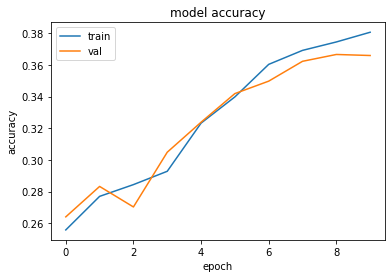

In [111]:
plt.plot(train_accuracy)
plt.plot(eval_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()